IA & Data science (LU3IN0226) -- 2022-2023
--------
*&copy; Equipe pédagogique: Christophe Marsala, Olivier Schwander, Jean-Noël Vittaut.*

#  Semaine 3 : algorithme du perceptron de Rosenblatt

<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

Anyes TAFOUGHALT
Ilyes DJERFAF

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>tme-03</tt> et rajouter à la suite de <tt>tme-03</tt> les noms des membres du binômes séparés par un tiret.

<font color="RED" size="+1">IMPORTANT: soumission de votre fichier final</font>

**Nom à donner au fichier à poster** : *tme-03-Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme
- ne pas compresser ou faire une archive: il faut rendre le fichier ipython tel quel, éventuellement, si vous avez d'autres fichiers vous les rendez séparément.

**Echancier pour la soumission de votre compte-rendu:**
- le compte-rendu d'une séance doit être remis obligatoirement <font color="RED">avant la séance suivante</font>.

**Le compte-rendu est soumis sur la page Moodle.**

Les imports suivants seront généralement nécessaires:

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline  

# Les instructions suivantes sont TRES utile pour recharger automatiquement 
# le code modifié dans les librairies externes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Retour sur le sujet du TME 2

In [4]:
# ------------------------ REPRENDRE ICI LES FONCTIONS SUIVANTES DU TME 2:
# genere_dataset_uniform:
def genere_dataset_uniform(p, n, binf=-1, bsup=1):
    """ int * int * float^2 -> tuple[ndarray, ndarray]
        Hyp: n est pair
        p: nombre de dimensions de la description
        n: nombre d'exemples de chaque classe
        les valeurs générées uniformément sont dans [binf,bsup]
    """
    t1 = np.random.uniform(binf, bsup, (2*n, p))
    t2 = np.asarray([-1 for i in range(0, n)] + [+1 for i in range(0, n)])
    return t1, t2
# genere_dataset_gaussian:
def genere_dataset_gaussian(positive_center, positive_sigma, negative_center, negative_sigma, nb_points):
    """ les valeurs générées suivent une loi normale
        rend un tuple (data_desc, data_labels)
    """
    exemple_classe_negative = np.random.multivariate_normal(
        negative_center, negative_sigma, nb_points)
    
    exemple_classe_positive = np.random.multivariate_normal(
        positive_center, positive_sigma, nb_points)
    
    t1 = np.vstack((exemple_classe_negative, exemple_classe_positive))
    t2 = np.asarray([-1 for i in range(0, nb_points)] +
                    [+1 for i in range(0, nb_points)])
    return t1, t2

# plot2DSet:
def plot2DSet(desc,labels):    
    """ ndarray * ndarray -> affichage
        la fonction doit utiliser la couleur 'red' pour la classe -1 et 'blue' pour la +1
    """
    # Extraction des exemples de classe -1:
    data_negatifs = desc[labels == -1]
    # Extraction des exemples de classe +1:
    data_positifs = desc[labels == +1]

    # Affichage de l'ensemble des exemples :
    # 'o' rouge pour la classe -1
    plt.scatter(data_negatifs[:, 0],
                data_negatifs[:, 1], marker='o', color="red")
    plt.scatter(data_positifs[:, 0], data_positifs[:, 1],
                marker='x', color="blue")  # 'x' bleu pour la classe +1

# plot_frontiere:
def plot_frontiere(desc_set, label_set, classifier, step=30):
    """ desc_set * label_set * Classifier * int -> NoneType
        Remarque: le 4e argument est optionnel et donne la "résolution" du tracé: plus il est important
        et plus le tracé de la frontière sera précis.        
        Cette fonction affiche la frontière de décision associée au classifieur
    """
    mmax=desc_set.max(0)
    mmin=desc_set.min(0)
    x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
    grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
    
    # calcul de la prediction pour chaque point de la grille
    res=np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res=res.reshape(x1grid.shape)
    # tracer des frontieres
    # colors[0] est la couleur des -1 et colors[1] est la couleur des +1
    plt.contourf(x1grid,x2grid,res,colors=["darksalmon","skyblue"],levels=[-1000,0,1000])



Taille du dataset généré : (200, 2) exemples
Les 5 premiers exemples :
<class 'numpy.ndarray'> 
 [[-0.00328585 -1.1382643 ]
 [ 0.14768854  0.52302986]
 [-0.73415337 -1.23413696]
 [ 1.07921282 -0.23256527]
 [-0.96947439 -0.45743996]]


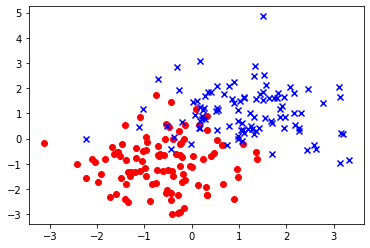

In [5]:
# Exemple d'utilisation:
np.random.seed(42)   # on prend 42 comme graine

# On génère un dataset de 200 exemples en dimension 2:
data_gauss_desc, data_gauss_label = genere_dataset_gaussian(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-0.5,-1]),np.array([[1,0],[0,1]]),100)

print("Taille du dataset généré :", np.shape(data_gauss_desc), "exemples")

print("Les 5 premiers exemples :")
print(type(data_gauss_desc), '\n', data_gauss_desc[0:5,:])

# Affichage des exemples générés:
plot2DSet(data_gauss_desc, data_gauss_label)

## Evaluation d'un algorithme d'apprentissage

Un algorithme d'apprentissage permet de construire ou mettre au point un modèle de prédiction qui pourra donner (on dit aussi prédire), pour tout nouvel exemple, le label à associer à cet exemple.
Si on connaît par ailleurs le vrai label de l'exemple, le label trouvé par le modèle est comparé à ce vrai label et on peut donc déterminer si le modèle s'est trompé ou s'il a raison.

Soit $f$ un modèle. Etant donné un ensemble $\bf X$ contenant $n$ exemples, et $Y$ l'ensemble des labels associés à ces exemples, tels que pour tout $\bf x_i \in \bf X$, $y_i$ est le label correspondant.

Un exemple $\bf x_i$ tel que $f(\bf x_i) = y_i$ est dit *bien classé par $f$*.
Un exemple $\bf x_i$ tel que $f(\bf x_i) \not= y_i$ est dit *mal classé par $f$*.

#### Taux de bonne classification
Le **taux de bonne classification** (ou *accuracy*) obtenu par $f$ pour les données de l'ensemble $\bf X$ est: 
$$\frac{n_{bc}}{n}$$

avec $n_{bc}$ le nombre d'exemples $\bf x_i$ de $\bf X$ bien classés par $f$, c'est-à-dire pour lesquels $f(\bf x_i) = y_i$.


#### Performance d'un modèle
Un modèle appris grâce à un algorithme d'apprentissage peut être évalué sur 2 aspects:
- sa capacité à rendre compte des données qui ont servi à le mettre au point : on évalue cela en mesurant son taux de bonne classification (ou *accuracy*) sur des données d'apprentissage.
- sa capacité à **généraliser** ce qu'il a appris sur des données qu'il ne connaît pas : on évalue cela en mesurant son taux de bonne classification (ou *accuracy*)  sur des données différentes de celles utilisées en apprentissage, on parle de **données test**.

Ainsi, un modèle appris qui est très performant sur les données d'apprentissage, mais qui a performances très faibles en prédiction sur d'autres données n'est souvent pas très intéressant. La capacité de généraliser est ce que l'on recherche en premier lieu pour un bon modèle.

#### Ensemble d'apprentissage et ensemble de test
Pour évaluer un modèle appris $f$, on a donc besoin de 2 ensembles d'exemples pour lesquels on connaît le label:
- la **base d'apprentissage** (ou *training set*): il est composé d'un ensemble d'exemples $\bf X$ associé à un ensemble de labels correspondant $Y$. La base d'apprentissage est l'ensemble que l'on utilise pour mettre au point le modèle lors de la phase *train*.
    - pour le knn, la base d'apprentissage correspond à l'ensemble que l'on mémorise.
    - pour le perceptron, la base d'apprentissage est utilisée pour trouver le bon paramétrage du modèle.
- la **base de test** (ou *test set*): il est composé d'un ensemble d'exemples $\bf X_t$ associé à un ensemble de labels correspondant $Y_t$. Les exemples de la base de test ne sont pas utilisés durant la phase d'apprentissage. Ces exemples ne sont utilisés que pour calculer un taux de bonne classification du modèle.

#### Evaluation d'un modèle
Pour évaluer correctement un modèle, on doit fournir 2 taux de bonne classification(ou *accuracy*) :
- le taux de bonne classification sur la base d'apprentissage;
- le taux de bonne classification sur une base de test.


## Construction d'une base d'apprentissage et d'une base de test

Dans la pratique, on possède généralement une seule base d'exemples (cf. données USPS du TME 2) à partir de laquelle on construit les 2 bases nécessaires.
Soit $\bf X$ un ensemble de $n$ exemples et $Y$ l'ensemble des labels associés (ie. tout $\bf x_i \in \bf X$ a pour label $y_i \in Y$, pour $i=1,.., n$).

- la base d'apprentissage $(\bf X_{train}, Y_{train})$ est construite en sélectionnant aléatoirement $n_+$ exemples de label $+1$ et $n_-$ exemples de labels $-1$ (généralement $n_+ = n_-$).
- la base de test $(\bf X_{test}, Y_{test})$ est construire en prenant tous les exemples de $\bf X$ qui n'ont pas été sélectionnés dans $\bf X_{train}$.


<font color="RED" size="+1">**[Q]**</font>  Ecrire la fonction `genere_train_test` qui, étant donné deux `ndarray`, un donnant des descriptions et l'autre les labels correspondants, rend 2 tuples:
- le premier tuple correspond à la base d'apprentissage $(\bf X_{train}, Y_{train})$
- le deuxième tuple correspond à la base de test $(\bf X_{test}, Y_{test})$

Pour écrire cette fonction, on peut utiliser la fonction `random.sample` de la librairie `random` (attention, cette librairie contient des fonctions différentes des fonctions random de la librairie numpy que l'on a utilisé jusqu'à présent).
La fonction `random.sample` prend 2 arguments: une liste $L$ et un entier $k$, et elle rend $k$ éléments de $L$ choisis aléatoirement (sans remise).

In [6]:
# Exemple d'utilisation de la fonction random.sample:

import random
random.seed(42)  # pour avoir les mêmes tirages

# Choix aléatoire de 5 éléments de la liste:
random.sample([i for i in range(0,100)], 5)

[81, 14, 3, 94, 35]

In [7]:
# A quoi correspond le résultat de cette commande ?:

L = random.sample([i for i in range(0,data_gauss_desc.shape[0])],10)
data_gauss_desc[L]

array([[ 0.08685709,  1.19045563],
       [-0.69236096, -0.69845266],
       [-0.13860439,  0.53803657],
       [ 1.87232064,  1.18334201],
       [-1.176922  , -0.38832371],
       [-0.44808434, -0.40746377],
       [ 3.18980293,  0.19170171],
       [ 1.06980208,  0.6146864 ],
       [-1.97852199, -1.71984421],
       [ 1.74729361,  1.61037027]])

In [8]:
# A quoi correspond le résultat de cette commande ?:
data_gauss_desc[data_gauss_label == -1].shape

(100, 2)

Ainsi, si la liste L contient les indices de tous les exemples d'une base d'exemples, il devient facile de sélectionner un sous-ensemble de ces exemples en tirant aléatoirement leurs indices par cette fonction.

In [9]:
# ------------------------ A COMPLETER
def genere_train_test(desc_set, label_set, n_pos, n_neg):
    """ permet de générer une base d'apprentissage et une base de test
        desc_set: ndarray avec des descriptions
        label_set: ndarray avec les labels correspondants
        n_pos: nombre d'exemples de label +1 à mettre dans la base d'apprentissage
        n_neg: nombre d'exemples de label -1 à mettre dans la base d'apprentissage
        Hypothèses: 
           - desc_set et label_set ont le même nombre de lignes)
           - n_pos et n_neg, ainsi que leur somme, sont inférieurs à n (le nombre d'exemples dans desc_set)
    """
    n = desc_set.shape[0]
    neg = [i for i in range(n) if label_set[i]==-1]
    pos = [i for i in range(n) if label_set[i]==1]
    neg = random.sample(neg,n_neg)
    pos = random.sample(pos,n_pos)

    train_index = np.concatenate((neg , pos ))
    total_index = np.array([i for i in range(n)])
    test_index = np.setdiff1d(total_index, train_index)

    return ( desc_set[train_index] ,label_set[train_index]  ) , ( desc_set[test_index] ,label_set[test_index]  )

<font color="RED" size="+1">**[Q]**</font>  Utiliser la fonction précédente pour générer une base d'apprentissage et une base de test à partir des données aléatoires gaussiennes générées plus haut. La base d'apprentissage contiendra 75 exemples de la classe +1 et 75 exemples de la classe -1.

In [10]:
random.seed(42)
(train_desc, train_label), (test_desc, test_label) = genere_train_test(data_gauss_desc, data_gauss_label,75,75)

print("Base d'apprentissage: ",train_desc.shape, " et ", len(train_label)," labels")
print("Base de test: ",test_desc.shape, " et ", len(test_label)," labels")

Base d'apprentissage:  (150, 2)  et  150  labels
Base de test:  (50, 2)  et  50  labels


## Perceptron de Rosenblatt

De la même façon que nous avons défini des classes pour le classifieur par k-ppv et le classifieur linéaire aléatoire, nous allons maintenant définir une nouvelle classe de classifieurs pour implémenter un nouvel algorithme d'apprentissage : le **perceptron de Rosenblatt**.

<div class="alert alert-block alert-info">

**Apprentissage d'un perceptron**<BR>
L'apprentissage d'un perceptron consiste à partir d'une base de données étiquetées $\mathbf X \in \mathbb R^{n\times d}, \mathbf Y\in \{-1,1\}^n$ de fournir un **vecteur de paramètres** optimisés, de dimension $d$, $\mathbf w\in \mathbb R^{d}$.

Le perceptron est représenté par le vecteur $\mathbf w$ et on utilise comme paramètre pour le mettre au point un *learning rate* $\epsilon \in [0,1]$ qui est défini à la création du classifieur (paramètre du constructeur).
    
En termes algorithmiques, l'apprentissage est itératif:
1. Initialisation de $\mathbf w$: il y a 2 façons possibles (à choisir), $\mathbf w$ est initialisé soit comme vecteur nul (toutes ses composantes à 0), soit aléatoirement. 
    
    *Attention, si l'initialisation est aléatoire, **les valeurs doivent être très petites** et également réparties entre valeurs positives et négatives pour ne pas biaiser l'algorithme. On pourra dans ce cas pour générer chaque composante de $\mathbf w$: 1) générer aléatoirement une valeur $v$ dans $[0,1[$, 2) la transformer en $2v-1$ pour qu'elle soit dans $[-1,1[$, puis 3) la multiplier par un nombre réel positif petit (par exemple $0.001$) pour obtenir une valeur très petite.*
1. Optimisation stochastique grâce à la base d'apprentissage $\mathbf X$:
    1. Choisir aléatoirement un exemple $\mathbf x_i$ de $\mathbf X$
    1. Calculer le score $\hat y_i$ fourni par le perceptron par $\hat y_i = \mathbf x_i \cdot \mathbf w$ en utilisant le vecteur $\mathbf w$ courant
        - le label associé $\hat y_i^*$ obtenu en prenant le signe de $\hat y_i$ correspond à la prédiction (+1 ou -1) faite par le perceptron pour $\mathbf x_i$.
    1. Evaluer l'erreur de prédiction pour $\mathbf x_i$, sachant que le label à trouver doit être $y_i$ (donné dans $\mathbf Y$). 
        1. Si *pas d'erreur*, pas de correction à faire
        1. Si *erreur*, corriger $\mathbf w$ par : 
        $$\mathbf w \leftarrow \mathbf w + \epsilon y_i \mathbf x_i$$
       
    1. Arrêter lorsqu'il y a convergence:
        1. Convergence = aucun ou peu de changements sur $\mathbf w$ pendant $n$ itérations. Pour évaluer le changement, on calcule la norme de la valeur absolue de la différence terme à terme entre $w$ (vecteur avant l'étape 2) et $w'$ (vecteur après l'étape 2). Il y a convergence quand cette valeur descend en dessous d'un seuil de convergence (qui est un réel positif non nul).
        1. Remarque : on peut fixer un nombre d'itérations maximum au bout desquelles l'algorithme doit s'arrêter pour ne pas se coincer dans une boucle infinie.

**Classification / Prédiction / Inférence avec un perceptron**<BR>
L'inférence est linéaire: 
    $$\hat y_i =  \mathbf x_i \cdot \mathbf w , \qquad \hat y_i^* =\text{sign}(\hat y_i) \in \{-1,1\}$$
   
   $\hat y_i$ correspond au score fourni par le perceptron (valeur réelle donc) et $y_i^*$ correspond à la prédiction (+1 ou -1).
    
<br/>
<b>Remarque:</b> attention à ne pas confondre l'évaluation linéaire à valeur réelle et le signe qui permet de mettre notre estimation dans le même univers que les étiquettes d'origine.
    
    
</div>    

<font color="RED" size="+1">**[Q]**</font> En héritant de la classe `Classifier` (qu'il faut donc récupérer pour la mettre dans ce notebook), écrire la classe `ClassifierPerceptron` qui implémente l'algorithme du perceptron de Rosenblatt vu en cours. 

Lors de l'initialisation, dans la méthode `__init__`, deux paramètres seront fournis:
- le learning_rate (`epsilon`) du perceptron (par défaut, il sera mis à $0.01$). 
- un argument booléen de nom `init` qui vaut `True` (par défaut) ou `False` et qui donne le mode souhaité d'initialisation du perceptron: soit en mettant les poids $w_1, \ldots, w_d$ à 0 (valeur `True`), soit en les initialisant aléatoirement par des valeurs très petites (valeur `False`) comme expliqué dans le descriptif ci-dessus.

Pour l'apprentissage du perceptron, on écrit les 2 fonctions suivantes.

La fonction `train_step` réalise **une unique itération de tous les exemples** du dataset d'apprentissage $\mathbf X$ en prenant ces exemples dans un ordre aléatoire (cf. shuffle expliqué ci-après). Cet ordre doit être tiré aléatoirement au moment de l'exécution de la fonction `train_step` (à chaque lancement de `train_step`, l'ordre devra donc être différent). Une fois un exemple $\mathbf x$ choisi, on applique l'algorithme expliqué dans le cadre précédent.

La fonction `train` implémente l'algorithme complet de l'apprentissage itératif du perceptron jusqu'à sa convergence (elle appelle donc la fonction `train_step`). Elle prend en argument, en plus du dataset, un entier `nb_max` qui donne le nombre d'itérations maximal à réaliser, et un réel `seuil` qui donne le seuil de convergence à atteindre. Cette fonction rend la liste des valeurs des différences rencontrées.

Remarque: quelques fonctions utiles :
- la fonction `np.zeros` qui prend en argument un entier. Par exemple, tester `np.zeros(10)`.
- la fonction `np.random.shuffle` qui prend une liste de valeurs en arguments et la modifie (par effet de bord) en réordonnant aléatoirement les valeurs.
- pour copier un `np.array`, il est nécessaire d'utiliser la méthode `copy()` qui réalise une copie profonde. Par exemple, `B = A.copy()` pour copier le `np.array A` dans la variable `B`.

**IMPORTANT**: dans tous les exemples ci-dessous, on utilise toujours la même graine (seed) de génération de nombres aléatoires, ceci pour vous permettre de mettre au point vos fonctions, une fois qu'elles sont mises au point, il vous faut alors réaliser des expérimentations **sans utiliser de graine**.

In [11]:
# Par exemple :

np.random.seed(42)   # on prend 42 comme graine

l =[i for i in range(0,10)]
print("Avant: ",l)
np.random.shuffle(l)
print("Après: ",l)

Avant:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Après:  [8, 1, 5, 0, 7, 2, 9, 4, 3, 6]


In [12]:
# ------------------------ A COMPLETER :

# Recopier ici la classe Classifier (complète) du TME 2
class Classifier:
    """ Classe (abstraite) pour représenter un classifieur
        Attention: cette classe est ne doit pas être instanciée.
    """
    
    def __init__(self, input_dimension):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension de la description des exemples
            Hypothèse : input_dimension > 0
        """
        if input_dimension <= 0:
            raise ValueError(
                "La dimension de la description des exemples doit etre strictement positive")
        else:
            self.dimension = input_dimension
        # raise NotImplementedError("Please Implement this method")
        
    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        raise NotImplementedError("Please Implement this method")
    
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        raise NotImplementedError("Please Implement this method")
    
    def predict(self, x):
        """ rend la prediction sur x (soit -1 ou soit +1)
            x: une description
        """
        raise NotImplementedError("Please Implement this method")

    def accuracy(self, desc_set, label_set):
        """ Permet de calculer la qualité du système sur un dataset donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """
        # ------------------------------
        # COMPLETER CETTE FONCTION ICI : 
        resultat = [self.predict(desc_set[i]) for i in range(0, len(label_set))]
        equal_count = sum([1 for i in range(0, len(label_set))
                          if label_set[i] == resultat[i]])
        return equal_count / len(label_set)
        # ............


        # ------------------------------


In [25]:
# ------------------------ A COMPLETER : DEFINITION DU CLASSIFIEUR PERCEPTRON

class ClassifierPerceptron(Classifier):
    """ Perceptron de Rosenblatt
    """
    def __init__(self, input_dimension, learning_rate=0.01, init=True ):
        """ Constructeur de Classifier
            Argument:
                - input_dimension (int) : dimension de la description des exemples (>0)
                - learning_rate (par défaut 0.01): epsilon
                - init est le mode d'initialisation de w: 
                    - si True (par défaut): initialisation à 0 de w,
                    - si False : initialisation par tirage aléatoire de valeurs petites
        """
        self.epsilon =  learning_rate
        if init :
            self.w = np.zeros(input_dimension)
        else:
            self.w = [ 0.001*(2*np.random.rand()-1) for i in range(input_dimension) ]
                
        
    def train_step(self, desc_set, label_set):
        """ Réalise une unique itération sur tous les exemples du dataset
            donné en prenant les exemples aléatoirement.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
        """
        n =  len(desc_set)       
        index =[i for i in range(n)]
        np.random.shuffle(index)
        for i in range(n) :
            label = self.predict(desc_set[index[i]])
            if label != label_set[index[i]]:
                self.w = self.w + self.epsilon * label_set[index[i]] * desc_set[index[i]]
        
     
    def train(self, desc_set, label_set, nb_max=100, seuil=0.001):
        """ Apprentissage itératif du perceptron sur le dataset donné.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
                - nb_max (par défaut: 100) : nombre d'itérations maximale
                - seuil (par défaut: 0.001) : seuil de convergence
            Retour: la fonction rend une liste
                - liste des valeurs de norme de différences
        """        
        converge = False
        cpt = 0
        norms=[]
        #est ce que on ajoute les w ou les différences 
        while(not converge and cpt < nb_max):
            w_1 = self.w.copy()
            self.train_step(desc_set, label_set )
            diff = w_1 - self.w
            norm = np.linalg.norm(diff)
            norms.append(norm)
            if norm < seuil :
                converge = True
            cpt+=1
        return norms
    
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        return np.dot(x, self.w)
    
    def predict(self, x):
        """ rend la prediction sur x (soit -1 ou soit +1)
            x: une description
        """
        score = self.score(x)
        return +1 if score >= 0 else -1

    

## Validation de l'algorithme

<font color="RED" size="+1">**[Q]**</font>  Afin de vérifier le bon fonctionnement de l'algorithme, nous allons procéder à plusieurs tests:

1. Expérimentation avec les gaussiennes jouets définies dans le TME 2
    1. Vérifier l'impact du réglage de l'initialisation (normalement, il n'y a pas trop d'impact sur un problème aussi simple)
    1. Vérifier l'impact du réglage de epsilon (impact énorme: ca diverge très rapidement!!)
    1. En jouant sur la génération des données, tester votre perceptron dans le cas facile (nuages des deux classes bien séparés) puis dans le cas plus difficile où les classes ne sont plus séparables linéairement.

1. Expérimentation avec les données USPS (cf. TME 2)
    1. Nous travaillerons uniquement dans le cas binaire. Prendre les 1 vs 2 (cas facile) puis les 3 vs 6 ou 9 (cas nettement plus dur)
    
1. Penser à faire le parallèle avec le temps pour prédire avec les k-ppv de la semaine précédente
    
**Note:** il faut évidemment multiplier les boites et ne pas tout faire au même endroit.

### Test sur des gaussiennes jouets

#### Apprentissage pas à pas et variation d'accuracy

Init perceptron : w= [0. 0.]


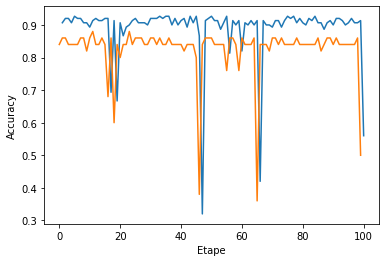

Accuracy finale (train):  0.56
Accuracy finale (test) :  0.5


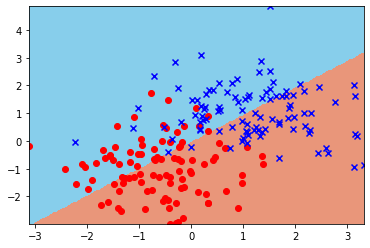

In [21]:
# ------------------------ COMPLETER LES INSTRUCTIONS DANS CETTE BOITE 

np.random.seed(42)   # on prend 42 comme graine pour tester

# -----
# Création d'un perceptron avec initialisation à 0 et le learning_rate ci-dessous:
learning_rate = 0.01
perceptron1 = ClassifierPerceptron(2, learning_rate)

# -----
# Définition des données d'apprentissage (on reprend les données data_gauss générées plus haut)
random.seed(42)
(train_desc, train_label), (test_desc, test_label) = genere_train_test(data_gauss_desc, data_gauss_label,75,75)

data_train = train_desc
label_train = train_label
data_test = test_desc
label_test = test_label

# -----
# Apprentissage pas à pas du perceptron et mémorisation de l'accuracy à chaque étape:
# Listes qui vont servir à mémoriser les accuracy du perceptron à chaque étape:
train_acc = []
test_acc = []


# Réalisation de N itérations
N = 100
# [*** A COMPLETER ***]
print("Init perceptron : w=", perceptron1.w)
for i in range(N):
    perceptron1.train_step(data_train,label_train)
    train_acc.append( perceptron1.accuracy(data_train , label_train))
    test_acc.append( perceptron1.accuracy(data_test , label_test) )


# -----
# Traçage de la courbe des variations d'accuracy
plt.plot(range(1,N+1),train_acc,test_acc)  
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.show()

# -----
# Affichage de la frontière de séparation des classes (en prenant tous les exemples de la base)
plot_frontiere(data_gauss_desc,data_gauss_label,perceptron1,step=150)
plot2DSet(data_gauss_desc,data_gauss_label)

print("Accuracy finale (train): ",train_acc[-1] )
print("Accuracy finale (test) : ", test_acc[-1] )


Init perceptron : w= [-0.000250919762305275, 0.0009014286128198323]


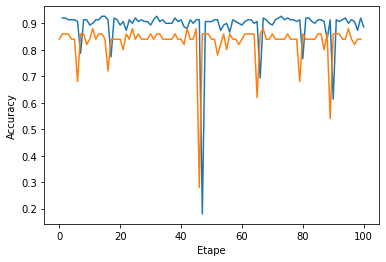

Accuracy finale (train):  0.8866666666666667
Accuracy finale (test) :  0.84


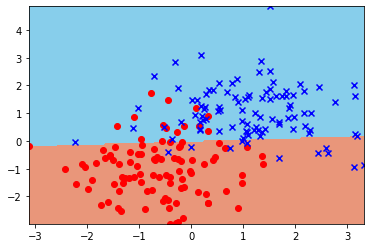

In [22]:

np.random.seed(42)   # on prend 42 comme graine pour tester

# -----
# Création d'un perceptron avec le learning_rate ci-dessous:
learning_rate = 0.01
perceptron12 = ClassifierPerceptron(2, learning_rate,False)

# -----
# Définition des données d'apprentissage (on reprend les données data_gauss générées plus haut)
random.seed(42)
(train_desc, train_label), (test_desc, test_label) = genere_train_test(data_gauss_desc, data_gauss_label,75,75)

data_train = train_desc
label_train = train_label
data_test = test_desc
label_test = test_label

# -----
# Apprentissage pas à pas du perceptron et mémorisation de l'accuracy à chaque étape:
# Listes qui vont servir à mémoriser les accuracy du perceptron à chaque étape:
train_acc = []
test_acc = []


# Réalisation de N itérations
N = 100
# [*** A COMPLETER ***]
print("Init perceptron : w=", perceptron12.w)
for i in range(N):
    perceptron12.train_step(data_train,label_train)
    train_acc.append( perceptron12.accuracy(data_train , label_train))
    test_acc.append( perceptron12.accuracy(data_test , label_test) )


# -----
# Traçage de la courbe des variations d'accuracy
plt.plot(range(1,N+1),train_acc,test_acc)  
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.show()

# -----
# Affichage de la frontière de séparation des classes (en prenant tous les exemples de la base)
plot_frontiere(data_gauss_desc,data_gauss_label,perceptron12,step=150)
plot2DSet(data_gauss_desc,data_gauss_label)

print("Accuracy finale (train): ",train_acc[-1] )
print("Accuracy finale (test) : ", test_acc[-1] )

Init perceptron : w= [0. 0.]


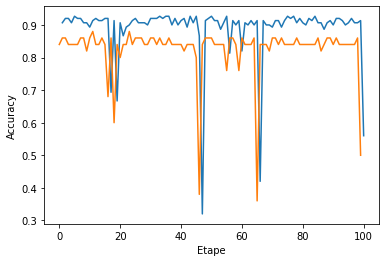

Accuracy finale (train):  0.56
Accuracy finale (test) :  0.5


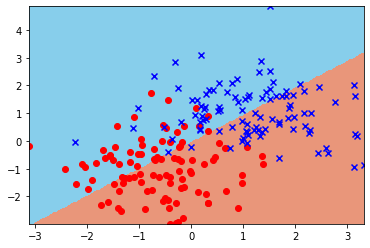

In [23]:
# ------------------------ COMPLETER LES INSTRUCTIONS DANS CETTE BOITE 

np.random.seed(42)   # on prend 42 comme graine pour tester

# -----
# Création d'un perceptron avec initialisation à 0 et le learning_rate ci-dessous:
learning_rate = 0.05
perceptron13 = ClassifierPerceptron(2, learning_rate)

# -----
# Définition des données d'apprentissage (on reprend les données data_gauss générées plus haut)
random.seed(42)
(train_desc, train_label), (test_desc, test_label) = genere_train_test(data_gauss_desc, data_gauss_label,75,75)

data_train = train_desc
label_train = train_label
data_test = test_desc
label_test = test_label

# -----
# Apprentissage pas à pas du perceptron et mémorisation de l'accuracy à chaque étape:
# Listes qui vont servir à mémoriser les accuracy du perceptron à chaque étape:
train_acc = []
test_acc = []


# Réalisation de N itérations
N = 100
# [*** A COMPLETER ***]
print("Init perceptron : w=", perceptron13.w)
for i in range(N):
    perceptron13.train_step(data_train,label_train)
    train_acc.append( perceptron13.accuracy(data_train , label_train))
    test_acc.append( perceptron13.accuracy(data_test , label_test) )


# -----
# Traçage de la courbe des variations d'accuracy
plt.plot(range(1,N+1),train_acc,test_acc)  
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.show()

# -----
# Affichage de la frontière de séparation des classes (en prenant tous les exemples de la base)
plot_frontiere(data_gauss_desc,data_gauss_label,perceptron13,step=150)
plot2DSet(data_gauss_desc,data_gauss_label)

print("Accuracy finale (train): ",train_acc[-1] )
print("Accuracy finale (test) : ", test_acc[-1] )

### Apprentissage et affichage de la convergence

Init perceptron : w= [-0.000250919762305275, 0.0009014286128198323]
Nb iterations réalisées:  9


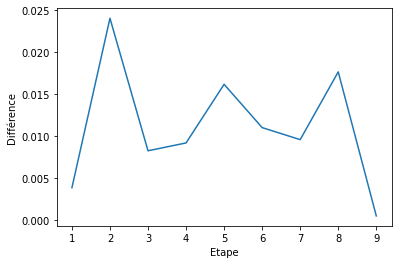

Accuracy finale (train):  0.9133333333333333
Accuracy finale (test) :  0.86


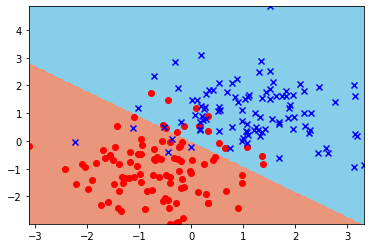

In [28]:
# ------------------------ COMPLETER LES INSTRUCTIONS DANS CETTE BOITE 

np.random.seed(42)   # on prend 42 comme graine

# Création d'un perceptron avec initialisation à 0 et le learning_rate ci-dessous:
learning_rate = 0.01
perceptron2 = ClassifierPerceptron(2, learning_rate,False)
# Définition des données d'apprentissage (on reprend les données data_gauss générées plus haut)
random.seed(42) 
(train_desc, train_label), (test_desc, test_label) = genere_train_test(data_gauss_desc, data_gauss_label,75,75)

data_train = train_desc
label_train = train_label
data_test = test_desc
label_test = test_label

print("Init perceptron : w=", perceptron2.w)
# Apprentissage du perceptron jusqu'à convergence
les_variations = perceptron2.train(data_train, label_train)
print("Nb iterations réalisées: ", len(les_variations) )

# Traçage de la courbe des variations
plt.plot(range(1,len(les_variations)+1),les_variations)  
plt.ylabel('Différence')
plt.xlabel("Etape")
plt.show()

# Affichage de la frontière de séparation des classes
plot_frontiere(data_gauss_desc,data_gauss_label,perceptron2,step=150)
plot2DSet(data_gauss_desc,data_gauss_label)

print("Accuracy finale (train): ", perceptron2.accuracy(data_train , label_train))
print("Accuracy finale (test) : ",  perceptron2.accuracy(data_test , label_test) )


Init perceptron: w=  [-0.00025092  0.00090143]
Nb iterations réalisées:  33


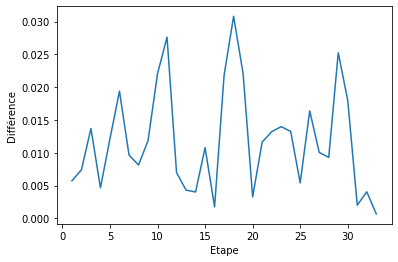

Accuracy finale (train):  0.8666666666666667
Accuracy finale (test) :  0.84


### Initialisation aléatoire et convergence

Init perceptron : w= [0. 0.]
Nb iterations réalisées:  100


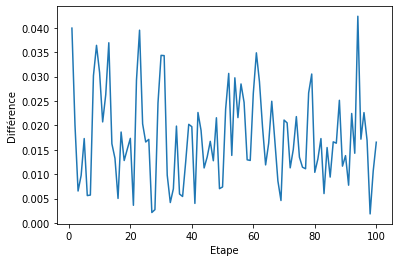

Accuracy finale (train):  0.56
Accuracy finale (test) :  0.5


In [29]:
# ------------------------ COMPLETER LES INSTRUCTIONS DANS CETTE BOITE 

np.random.seed(42)   # on prend 42 comme graine

# Création d'un perceptron avec initialisation aléatoire et le learning_rate ci-dessous:
learning_rate = 0.01
perceptron3 = ClassifierPerceptron(2, learning_rate)

# Définition des données d'apprentissage (on reprend les données data_gauss générées plus haut)
random.seed(42) 
(train_desc, train_label), (test_desc, test_label) = genere_train_test(data_gauss_desc, data_gauss_label,75,75)

data_train = train_desc
label_train = train_label
data_test = test_desc
label_test = test_label

print("Init perceptron : w=", perceptron3.w)
# Apprentissage du perceptron
les_variations = perceptron3.train(data_train, label_train)
print("Nb iterations réalisées: ", len(les_variations) )

# Traçage de la courbe des variations
plt.plot(range(1,len(les_variations)+1),les_variations)  
plt.ylabel('Différence')
plt.xlabel("Etape")
plt.show()

print("Accuracy finale (train): ", perceptron3.accuracy(data_train , label_train))
print("Accuracy finale (test) : ",  perceptron3.accuracy(data_test , label_test) )


Init perceptron: w=  [0. 0.]
Nb iterations:  100


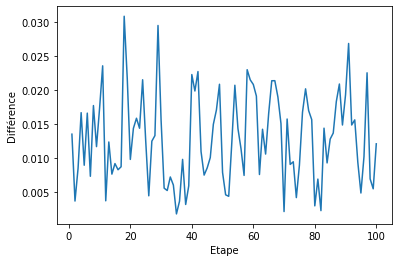

Accuracy finale (train):  0.7
Accuracy finale (test) :  0.62


### Impact du learning rate

<font color="RED" size="+1">[Q]</font> Tester différentes valeurs de learning rate et regarder les résultats en termes de convergence.

Par exemple, que se passe-t-il quand le learning rate est mis à 0.1?

Init perceptron : w= [0. 0.]
Nb iterations réalisées:  100


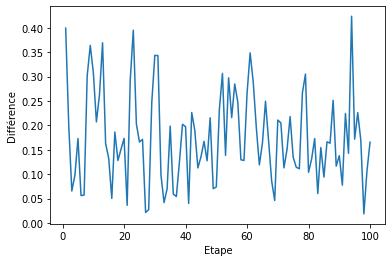

Accuracy finale (train):  0.56
Accuracy finale (test) :  0.5


In [30]:
# Par exemple : 

# ------------------------ COMPLETER LES INSTRUCTIONS DANS CETTE BOITE 

np.random.seed(42)   # on prend 42 comme graine

# Définition des données d'apprentissage (on reprend les données data_gauss générées plus haut)
random.seed(42) 
(train_desc, train_label), (test_desc, test_label) = genere_train_test(data_gauss_desc, data_gauss_label,75,75)

data_train = train_desc
label_train = train_label
data_test = test_desc
label_test = test_label

# Création d'un perceptron avec initialisation aléatoire et le learning_rate ci-dessous:
learning_rate = 0.1
perceptron4 = ClassifierPerceptron(2, learning_rate)

print("Init perceptron : w=", perceptron4.w)
# Apprentissage du perceptron
les_variations = perceptron4.train(data_train, label_train)
print("Nb iterations réalisées: ", len(les_variations) )

# Traçage de la courbe des variations
plt.plot(range(1,len(les_variations)+1),les_variations)  
plt.ylabel('Différence')
plt.xlabel("Etape")
plt.show()

print("Accuracy finale (train): ", perceptron4.accuracy(data_train , label_train))
print("Accuracy finale (test) : ",  perceptron4.accuracy(data_test , label_test) )


Init perceptron: w=  [0. 0.]
Nb iterations:  1000


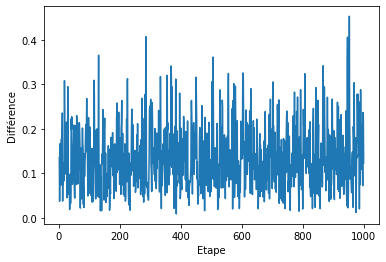

Accuracy finale (train):  0.88
Accuracy finale (test) :  0.84


<font color="RED" size="+1">[Q]</font> Quand le learning rate est mis à 0.01, en utilisant le paramètre `nb_max`, trouver combien d'itérations sont nécessaires pour que l'algorithme converge.

Init perceptron : w= [0. 0.]
Nb iterations réalisées:  148


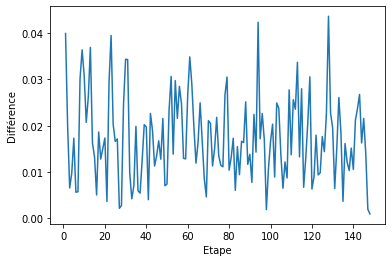

Accuracy finale (train):  0.9133333333333333
Accuracy finale (test) :  0.84


In [31]:
np.random.seed(42)   # on prend 42 comme graine

# Définition des données d'apprentissage (on reprend les données data_gauss générées plus haut)
random.seed(42) 
(train_desc, train_label), (test_desc, test_label) = genere_train_test(data_gauss_desc, data_gauss_label,75,75)

data_train = train_desc
label_train = train_label
data_test = test_desc
label_test = test_label

# Création d'un perceptron avec initialisation aléatoire et le learning_rate ci-dessous:
learning_rate = 0.01
perceptron5 = ClassifierPerceptron(2, learning_rate)

print("Init perceptron : w=", perceptron5.w)
# Apprentissage du perceptron
les_variations = perceptron5.train(data_train, label_train,500)
print("Nb iterations réalisées: ", len(les_variations) )

# Traçage de la courbe des variations
plt.plot(range(1,len(les_variations)+1),les_variations)  
plt.ylabel('Différence')
plt.xlabel("Etape")
plt.show()

print("Accuracy finale (train): ", perceptron5.accuracy(data_train , label_train))
print("Accuracy finale (test) : ",  perceptron5.accuracy(data_test , label_test) )



## Cas difficiles

<font color="RED" size="+1">[Q]</font> Afin de tester des cas plus difficiles (c'est-à-dire non séparables linéairement), écrire la fonction `createXOR` qui permet de générer le jeu de données ci-dessous. Cette fonction prend 2 arguments, un nombre de points $n$ et un réel positif $\sigma$ donnant la variance sur chaque dimension et permet de jouer sur la dispersion des nuages et donc sur la séparation des 4 nuages.

Il s'agit de générer des points dans deux classes mais selon 4 gaussiennes.

<img src="ressources/xor.png" width=300px>



In [ ]:
# ------------------------ COMPLETER LES INSTRUCTIONS DANS CETTE BOITE 
def create_XOR(n, var):
    """ int * float -> tuple[ndarray, ndarray]
        Hyp: n et var sont positifs
        n: nombre de points voulus
        var: variance sur chaque dimension
    """
    raise NotImplementedError("Please Implement this method")

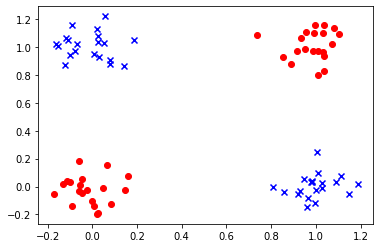

In [ ]:
# une fois le fichier d'outils mis à jour, vous devez pouvoir faire:

np.random.seed(42)   # on prend 42 comme graine

# Génération d'un dataset avec 80 points:
data_xor, label_xor = create_XOR(20,0.01)
plot2DSet(data_xor, label_xor)

<font color="RED" size="+1">[Q]</font> Appliquer l'algorithme du perceptron sur ces données et constater (avec quelques affichages de performances et tracés de frontières de décision) que ça ne marche pas!

In [ ]:
np.random.seed(42)   # on prend 42 comme graine

# Création d'un perceptron
perceptron_xor = ClassifierPerceptron(2,0.01)

# ------------------------ A COMPLETER :





## Expérimentations

Compléter ce notebook par des expérimentations sur le Perceptron, par exemple :
1. Test sur les données USPS (cf. TME 2)
    1. Pour réduire la place disque prise par la base USPS, commenc
    1. Nous travaillerons uniquement dans le cas binaire. Prendre les 1 vs 2 (cas facile) puis les 3 vs 6 ou 9 (cas nettement plus dur)
    
1. Faire le parallèle avec le temps d'inférence sur les k-ppv de la semaine précédente
